# COMP448 - Medical Image Analysis - Project

# Create and Save The Data After Performing:
    - Mean and Standard Deviation Normalization
    - Adaptive Histogram Equatization (CLAHE)
    - Extract the labels and save as PyTorch TensorDataset

## Şebnem Demirtaş - 76813
## Mete Erdoğan - 69666

In [14]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import shutil
import math
import random
from tqdm import tqdm
from PIL import Image

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Subset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights, resnet101, ResNet101_Weights
from torchvision.models import vit_l_16, ViT_L_16_Weights, vit_b_16, ViT_B_16_Weights

In [16]:
from collections import namedtuple, Counter
import torch.nn.functional as F
from torch.nn.functional import relu
from torch.utils.data import TensorDataset, DataLoader, random_split, ConcatDataset

In [17]:
from IPython.core.debugger import Pdb
import sys
import cv2 as cv
import pickle
import collections

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
random_seed = 448
torch.manual_seed(random_seed)

In [8]:
default_data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize(size = (224,224))])
directory = "chest_xray/chest_xray/train/NORMAL/"
images = []
for filename in os.listdir(directory):
    if filename.endswith(".jpeg") or filename.endswith(".png"):
        image_path = os.path.join(directory, filename)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE) #Image.open(image_path)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = default_data_transforms(image)
        images.append(image)

directory = "chest_xray/chest_xray/train/PNEUMONIA/"
for filename in os.listdir(directory):
    if filename.endswith(".jpeg") or filename.endswith(".png"):
        image_path = os.path.join(directory, filename)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE) #Image.open(image_path)
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = default_data_transforms(image)
        images.append(image)

all_imgs_tensor = torch.cat(images, dim=0)
mean, std = torch.mean(all_imgs_tensor), torch.std(all_imgs_tensor)

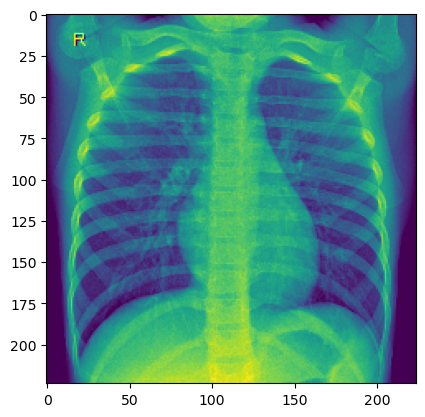

In [9]:
plt.imshow(images[0].permute(1,2,0))

In [10]:
def read_images(directory, transform=None):
    images = []
    labels = []
    im_dir = directory + "NORMAL/"
    for filename in os.listdir(im_dir):
        if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(im_dir, filename)
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            image = clahe.apply(image)
            
            if transform:
                image = transform(image)
            images.append(image)
            
            label = torch.tensor(0)
            labels.append(label)
            
    im_dir = directory + "PNEUMONIA/"
    for filename in os.listdir(im_dir):
        if filename.endswith(".jpeg") or filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(im_dir, filename)
            image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
            clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            image = clahe.apply(image)
            
            if transform:
                image = transform(image)
            images.append(image)
            
            if("virus" in filename):
                label = torch.tensor(1)
            elif("bacteria" in filename):
                label = torch.tensor(2)                  
            labels.append(label)
            
    return torch.stack(images), torch.stack(labels)

norm_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize(size = (224,224)), transforms.Normalize(mean = mean, std = std)])
images_tr, label_tr = read_images("chest_xray/chest_xray/train/", transform=norm_transforms)
images_ts, label_ts = read_images("chest_xray/chest_xray/test/", transform=norm_transforms)

In [11]:
print(images_tr.shape)
print(images_ts.shape)

torch.Size([5216, 1, 224, 224])
torch.Size([624, 1, 224, 224])


In [12]:
print(label_tr.shape)
print(label_ts.shape)

torch.Size([5216])
torch.Size([624])


In [13]:
train_dataset = TensorDataset(images_tr, label_tr)
test_dataset = TensorDataset(images_ts, label_ts)

with open("train_datax.pickle", 'wb') as file:
    pickle.dump(train_dataset, file)
    
with open("test_datax.pickle", 'wb') as file:
    pickle.dump(test_dataset, file)

In [25]:
def get_class_distribution(dataset):
    labels = [label.item() for _, label in dataset]
    return Counter(labels)

# Load the saved pickle data

In [20]:
with open("train_data.pickle", 'rb') as file:
    loaded_data1 = pickle.load(file)
    train_dataset = loaded_data1
    
with open("test_data.pickle", 'rb') as file:
    loaded_data2 = pickle.load(file)
    test_dataset = loaded_data2

In [55]:
train_dataloaderx = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [22]:
def get_class_distribution(dataset):
    labels = [label.item() for _, label in dataset]
    return Counter(labels)

In [23]:
get_class_distribution(train_dataset)

Counter({0: 1341, 2: 2530, 1: 1345})

In [24]:
get_class_distribution(test_dataset)

Counter({0: 234, 2: 242, 1: 148})